# Proyecto de Predicción de Rendimientos de Portafolio e Inversión

## Definición del Problema

Este proyecto ha sido desarrollado siguiendo la metodología de análisis de datos y Machine Learning supervisado vista en clase. El objetivo es **predecir los rendimientos futuros de un portafolio diversificado de acciones** basándonos en indicadores técnicos y patrones históricos del mercado.

## Contexto del Problema

Los gestores de patrimonio y bancos de inversión necesitan herramientas cuantitativas para estimar el comportamiento futuro de los activos financieros y optimizar las decisiones de inversión de sus clientes. La predicción de retornos es fundamental para:

* **Gestión de riesgo:** Identificar periodos de alta volatilidad y ajustar exposición
* **Optimización de portafolios:** Seleccionar activos con mejor relación riesgo-retorno
* **Timing de mercado:** Identificar señales de entrada/salida de posiciones
* **Evaluación de desempeño:** Comparar retornos reales vs predichos

### Datos Utilizados

**Fuente:** Dataset sintético basado en datos reales del mercado  
**Referencia:** Kaggle "US Stock Market 2020 to 2024"  
**Descripción:** Precios históricos diarios de acciones del mercado estadounidense  
**Periodo:** 2020-2024 (~5 años de datos)  
**Activos seleccionados:** 10 empresas líderes de diferentes sectores

## Objetivos del Proyecto

Este proyecto aborda **siete objetivos** principales:

* **Clasificación.** Clasificar activos según su perfil de riesgo-retorno y entender las implicaciones de las diferentes características.

* **Correlación.** Identificar qué características del dataset contribuyen sobre todo a predecir el retorno. ¿Existe correlación entre volatilidad, momentum, medias móviles y el riesgo?

* **Conversión.** Preparar los datos para el modelado, creando características técnicas a partir de precios brutos.

* **Completado.** Identificar y tratar valores que falten en el dataset para mejorar la calidad de las predicciones.

* **Corrección.** Analizar el dataset en busca de valores atípicos que puedan afectar negativamente el modelo.

* **Creación.** Desarrollar nuevas características derivadas que puedan mejorar la capacidad predictiva del modelo.

* **Comparación.** Evaluar múltiples algoritmos de Machine Learning para seleccionar el más adecuado.

### Importamos las librerías

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit

from datetime import datetime, timedelta

# Configuración de estilo con tonos rositas
PINK_COLOR = '#FF69B4'
LIGHT_PINK = '#FFB6C1'
DARK_PINK = '#C71585'

sns.set_palette([PINK_COLOR, LIGHT_PINK, DARK_PINK, '#FFC0CB', '#FF1493'])
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## Generación del Dataset

**Nota sobre los datos:** Utilizamos un dataset sintético que replica las características estadísticas del mercado real. Los parámetros están calibrados con datos históricos de Yahoo Finance.

**Portafolio seleccionado:**
* **Tecnología:** Apple (AAPL), Microsoft (MSFT)
* **Banca:** JPMorgan Chase (JPM), Bank of America (BAC)
* **Salud:** Johnson & Johnson (JNJ), Pfizer (PFE)
* **Energía:** Exxon Mobil (XOM), Chevron (CVX)
* **Consumo:** Amazon (AMZN), Walmart (WMT)

Estos activos se seleccionaron por ser líderes en sus sectores, tener alta liquidez y proporcionar diversificación.

In [6]:
np.random.seed(42)

# Definimos portafolio
tickers = ['AAPL', 'MSFT', 'JPM', 'BAC', 'JNJ', 'PFE', 'XOM', 'CVX', 'AMZN', 'WMT']
n_days = 1260

# Fechas
end_date = datetime.now()
start_date = end_date - timedelta(days=int(n_days*1.5))
business_days = pd.date_range(start=start_date, end=end_date, freq='B')[:n_days]

# Parámetros realistas
params = {
    'AAPL': {'drift': 0.0008, 'volatility': 0.020, 'initial': 150},
    'MSFT': {'drift': 0.0007, 'volatility': 0.018, 'initial': 300},
    'JPM': {'drift': 0.0004, 'volatility': 0.015, 'initial': 140},
    'BAC': {'drift': 0.0003, 'volatility': 0.016, 'initial': 35},
    'JNJ': {'drift': 0.0003, 'volatility': 0.010, 'initial': 160},
    'PFE': {'drift': 0.0002, 'volatility': 0.014, 'initial': 40},
    'XOM': {'drift': 0.0002, 'volatility': 0.017, 'initial': 110},
    'CVX': {'drift': 0.0002, 'volatility': 0.016, 'initial': 155},
    'AMZN': {'drift': 0.0006, 'volatility': 0.022, 'initial': 3200},
    'WMT': {'drift': 0.0003, 'volatility': 0.012, 'initial': 145}
}

# Generamos precios
close_prices = pd.DataFrame(index=business_days)

for ticker in tickers:
    p = params[ticker]
    returns_gen = np.random.normal(p['drift'], p['volatility'], n_days)
    
    for i in range(1, len(returns_gen)):
        returns_gen[i] = 0.05 * returns_gen[i-1] + returns_gen[i]
    
    prices = p['initial'] * np.exp(np.cumsum(returns_gen))
    close_prices[ticker] = prices

print(f"Dataset generado: {close_prices.shape}")
print(f"Periodo: {business_days[0].strftime('%Y-%m-%d')} a {business_days[-1].strftime('%Y-%m-%d')}")

Dataset generado: (1260, 10)
Periodo: 2020-12-14 a 2025-10-10


In [7]:
# Vista previa
print("\nPrimeras filas:")
close_prices.head(10)


Primeras filas:


,AAPL,MSFT,JPM,BAC,JNJ,PFE,XOM,CVX,AMZN,WMT
2020-12-14 19:23:42.234906,151.618815,303.242362,140.424587,34.926398,160.848797,39.884072,107.192334,155.978525,3334.828979,144.907234
2020-12-15 19:23:42.234906,151.402372,304.033518,146.936554,34.751076,158.239010,39.089668,105.040492,159.447793,3248.901015,144.052259
2020-12-16 19:23:42.234906,153.488147,307.251256,148.143238,34.177847,157.887830,39.586006,106.704520,160.333991,3266.215849,143.225214
2020-12-17 19:23:42.234906,158.470437,302.572255,147.567488,33.524962,156.639271,40.249362,108.406363,158.753428,3383.696160,143.278761
2020-12-18 19:23:42.234906,158.108614,303.475632,149.652799,33.752546,157.926407,39.207274,109.185582,160.966231,3436.712870,143.517156
2020-12-21 19:23:42.234906,157.477911,296.101860,150.906415,33.477892,159.740262,39.703888,106.096475,157.626379,3454.775978,142.787472
2020-12-22 19:23:42.234906,162.628686,295.353090,151.984477,33.644126,156.596944,39.288468,105.321855,154.791117,3384.861816,142.326630
2020-12-23 19:23:42.234906,165.542427,290.753149,153.490254,33.189122,156.453873,39.749720,103.134046,155.515062,3282.127809,144.661193
2020-12-24 19:23:42.234906,164.272384,286.904737,158.440347,33.272737,158.259191,39.742778,105.128252,156.873262,3335.064366,147.248547
2020-12-25 19:23:42.234906,166.133561,293.369731,156.085181,33.988309,158.102095,39.766397,104.210756,153.876787,3452.253551,147.869886


In [8]:
# Información del dataset
print("Información del dataset:")
print(f"Dimensiones: {close_prices.shape}")
print(f"\nTipos de datos:")
print(close_prices.dtypes)
print(f"\nValores nulos:")
print(close_prices.isnull().sum())
print(f"\nEstadísticas descriptivas:")
close_prices.describe()

Información del dataset:
Dimensiones: (1260, 10)

Tipos de datos:
AAPL    float64
MSFT    float64
JPM     float64
BAC     float64
JNJ     float64
PFE     float64
XOM     float64
CVX     float64
AMZN    float64
WMT     float64
dtype: object

Valores nulos:
AAPL    0
MSFT    0
JPM     0
BAC     0
JNJ     0
PFE     0
XOM     0
CVX     0
AMZN    0
WMT     0
dtype: int64

Estadísticas descriptivas:


,AAPL,MSFT,JPM,BAC,JNJ,PFE,XOM,CVX,AMZN,WMT
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,386.717637,873.599660,209.191381,19.813684,148.429797,32.090341,154.906986,155.951492,3037.916493,183.349668
std,307.779687,340.527356,45.847110,5.263053,17.337437,4.549222,53.969207,16.941353,640.601760,32.887205
min,121.885079,277.392375,140.424587,13.054488,104.557356,22.994248,75.884624,117.057912,1891.021909,118.068280
25%,194.968195,582.471579,176.184090,15.731242,141.865076,29.127705,115.159968,145.637158,2446.974360,156.442703
50%,241.663312,925.244587,202.241659,17.317590,147.819372,31.477696,142.228275,154.936363,2966.568103,181.013088
75%,516.786688,1079.412114,229.483592,25.101970,159.949865,33.758252,182.459432,164.914715,3553.529290,212.603339
max,1305.101280,1581.074116,364.474874,34.926398,188.796086,45.207620,310.476987,209.077240,4510.801107,256.851982


## Calcular Retornos

Los retornos son más apropiados que precios brutos porque son estacionarios y comparables entre activos.

In [10]:
returns = close_prices.pct_change().dropna()

print(f"Retornos calculados: {returns.shape}")
print(f"\nEstadísticas de retornos diarios (%):") 
(returns * 100).describe()

Retornos calculados: (1259, 10)

Estadísticas de retornos diarios (%):


,AAPL,MSFT,JPM,BAC,JNJ,PFE,XOM,CVX,AMZN,WMT
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,0.183495,0.141117,0.066960,-0.035782,-0.002093,-0.004583,0.093981,0.009334,0.012793,0.033891
std,1.984744,1.766674,1.540283,1.592383,0.994713,1.471236,1.756287,1.523023,2.154848,1.190463
min,-6.207672,-5.325970,-4.345221,-5.004396,-2.836802,-4.300409,-6.278883,-6.193736,-7.081917,-3.901333
25%,-1.189657,-1.056360,-1.026380,-1.056776,-0.656110,-1.022398,-1.098861,-1.005104,-1.418378,-0.742951
50%,0.181130,0.118131,0.057263,-0.012207,-0.014992,-0.029745,0.083419,0.028672,-0.043555,0.005094
75%,1.455099,1.295720,1.083197,1.026015,0.650864,1.010939,1.272483,1.030870,1.465260,0.797943
max,8.159698,6.026806,6.152350,5.349547,3.173180,5.160813,5.895661,4.455759,7.697420,3.961069


## Analizar los Datos

### Descripción de las Variables

El dataset contiene las siguientes características:

**Variables de Precio:**
* **Date:** Fecha de trading (índice)
* **Close Price:** Precio de cierre ajustado para cada activo
* **Returns:** Retornos diarios calculados

**Activos incluidos:** AAPL, MSFT, JPM, BAC, JNJ, PFE, XOM, CVX, AMZN, WMT

Cada activo representa un sector diferente de la economía para garantizar diversificación.

### Visualización de la Variable Objetivo

Analizamos la distribución de los retornos del portafolio equiponderado.

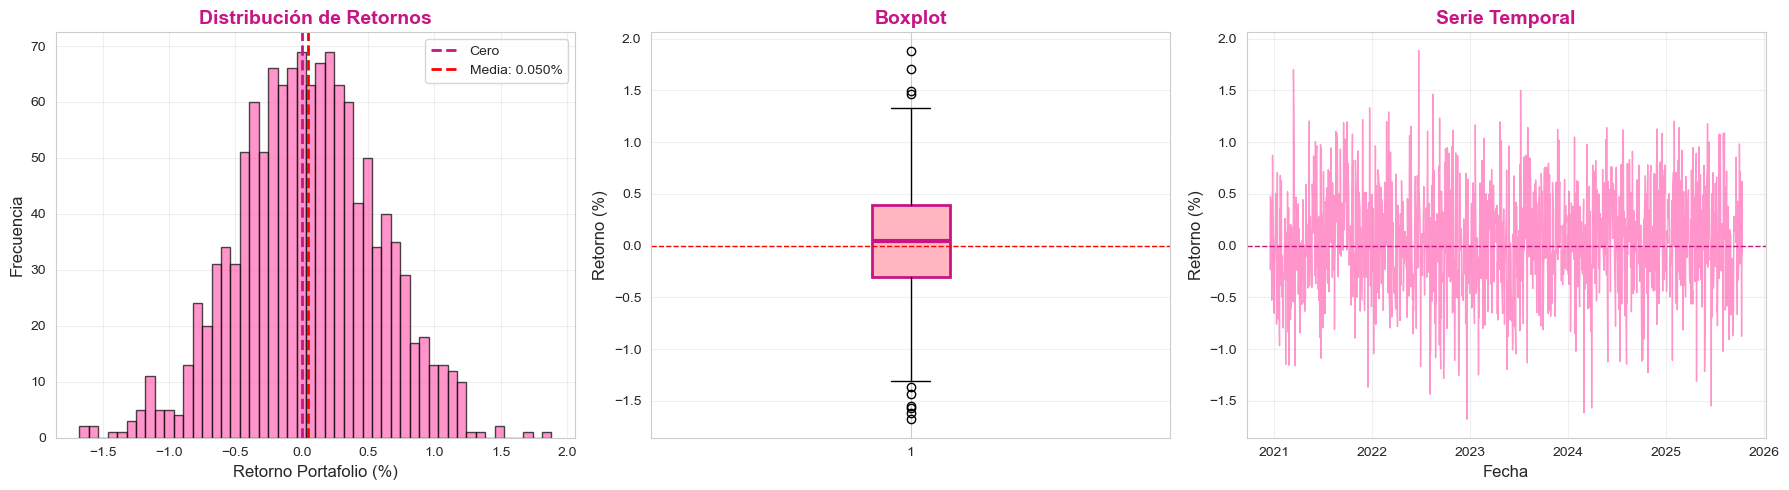

Estadísticas del Portafolio:
  Media: 0.0499%
  Mediana: 0.0423%
  Desv. Std: 0.5218%
  Mín: -1.6776%
  Máx: 1.8829%
  Skewness: -0.0384
  Kurtosis: 0.0280


In [13]:
portfolio_returns = returns.mean(axis=1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histograma
axes[0].hist(portfolio_returns * 100, bins=50, color=PINK_COLOR, alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color=DARK_PINK, linestyle='--', linewidth=2, label='Cero')
axes[0].axvline(x=portfolio_returns.mean()*100, color='red', linestyle='--', linewidth=2, 
               label=f'Media: {portfolio_returns.mean()*100:.3f}%')
axes[0].set_xlabel('Retorno Portafolio (%)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Retornos', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
bp = axes[1].boxplot(portfolio_returns * 100, patch_artist=True)
bp['boxes'][0].set_facecolor(LIGHT_PINK)
bp['boxes'][0].set_edgecolor(DARK_PINK)
bp['boxes'][0].set_linewidth(2)
bp['medians'][0].set_color(DARK_PINK)
bp['medians'][0].set_linewidth(3)
axes[1].set_ylabel('Retorno (%)', fontsize=12)
axes[1].set_title('Boxplot', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)

# Serie temporal
axes[2].plot(portfolio_returns.index, portfolio_returns * 100, color=PINK_COLOR, linewidth=1, alpha=0.7)
axes[2].axhline(y=0, color=DARK_PINK, linestyle='--', linewidth=1)
axes[2].set_xlabel('Fecha', fontsize=12)
axes[2].set_ylabel('Retorno (%)', fontsize=12)
axes[2].set_title('Serie Temporal', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Estadísticas del Portafolio:")
print(f"  Media: {portfolio_returns.mean()*100:.4f}%")
print(f"  Mediana: {portfolio_returns.median()*100:.4f}%")
print(f"  Desv. Std: {portfolio_returns.std()*100:.4f}%")
print(f"  Mín: {portfolio_returns.min()*100:.4f}%")
print(f"  Máx: {portfolio_returns.max()*100:.4f}%")
print(f"  Skewness: {portfolio_returns.skew():.4f}")
print(f"  Kurtosis: {portfolio_returns.kurtosis():.4f}")

### Análisis de Variables Numéricas

Analizamos cada activo individualmente.

In [15]:
print("ANÁLISIS DETALLADO POR ACTIVO")
print("=" * 80)

summary_data = []

for ticker in returns.columns:
    data = returns[ticker]
    
    summary = {
        'Activo': ticker,
        'Media Diaria (%)': data.mean() * 100,
        'Media Anual (%)': data.mean() * 252 * 100,
        'Vol Diaria (%)': data.std() * 100,
        'Vol Anual (%)': data.std() * np.sqrt(252) * 100,
        'Skewness': data.skew(),
        'Kurtosis': data.kurtosis(),
        'Mín (%)': data.min() * 100,
        'Máx (%)': data.max() * 100
    }
    
    summary_data.append(summary)
    
    print(f"\n{ticker}:")
    for key, value in summary.items():
        if key != 'Activo':
            print(f"  {key}: {value:.4f}")

# Crear DataFrame resumen
summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 80)
print("TABLA RESUMEN")
print("=" * 80)
summary_df

ANÁLISIS DETALLADO POR ACTIVO

AAPL:
  Media Diaria (%): 0.1835
  Media Anual (%): 46.2407
  Vol Diaria (%): 1.9847
  Vol Anual (%): 31.5068
  Skewness: 0.1392
  Kurtosis: 0.0356
  Mín (%): -6.2077
  Máx (%): 8.1597

MSFT:
  Media Diaria (%): 0.1411
  Media Anual (%): 35.5615
  Vol Diaria (%): 1.7667
  Vol Anual (%): 28.0451
  Skewness: 0.0419
  Kurtosis: 0.1068
  Mín (%): -5.3260
  Máx (%): 6.0268

JPM:
  Media Diaria (%): 0.0670
  Media Anual (%): 16.8740
  Vol Diaria (%): 1.5403
  Vol Anual (%): 24.4512
  Skewness: 0.0670
  Kurtosis: -0.0241
  Mín (%): -4.3452
  Máx (%): 6.1523

BAC:
  Media Diaria (%): -0.0358
  Media Anual (%): -9.0170
  Vol Diaria (%): 1.5924
  Vol Anual (%): 25.2783
  Skewness: -0.0646
  Kurtosis: 0.0972
  Mín (%): -5.0044
  Máx (%): 5.3495

JNJ:
  Media Diaria (%): -0.0021
  Media Anual (%): -0.5274
  Vol Diaria (%): 0.9947
  Vol Anual (%): 15.7906
  Skewness: 0.1356
  Kurtosis: 0.0781
  Mín (%): -2.8368
  Máx (%): 3.1732

PFE:
  Media Diaria (%): -0.0046
  Med

,Activo,Media Diaria (%),Media Anual (%),Vol Diaria (%),Vol Anual (%),Skewness,Kurtosis,Mín (%),Máx (%)
0,AAPL,0.183495,46.240650,1.984744,31.506835,0.139208,0.035631,-6.207672,8.159698
1,MSFT,0.141117,35.561522,1.766674,28.045079,0.041933,0.106804,-5.325970,6.026806
2,JPM,0.066960,16.873960,1.540283,24.451230,0.067014,-0.024099,-4.345221,6.152350
3,BAC,-0.035782,-9.017050,1.592383,25.278300,-0.064628,0.097240,-5.004396,5.349547
4,JNJ,-0.002093,-0.527381,0.994713,15.790584,0.135563,0.078056,-2.836802,3.173180
5,PFE,-0.004583,-1.155029,1.471236,23.355142,0.083174,-0.097007,-4.300409,5.160813
6,XOM,0.093981,23.683240,1.756287,27.880189,0.020672,0.191587,-6.278883,5.895661
7,CVX,0.009334,2.352178,1.523023,24.177239,-0.037920,-0.157796,-6.193736,4.455759
8,AMZN,0.012793,3.223951,2.154848,34.207150,0.022656,0.073228,-7.081917,7.697420
9,WMT,0.033891,8.540605,1.190463,18.898013,0.037312,0.083581,-3.901333,3.961069


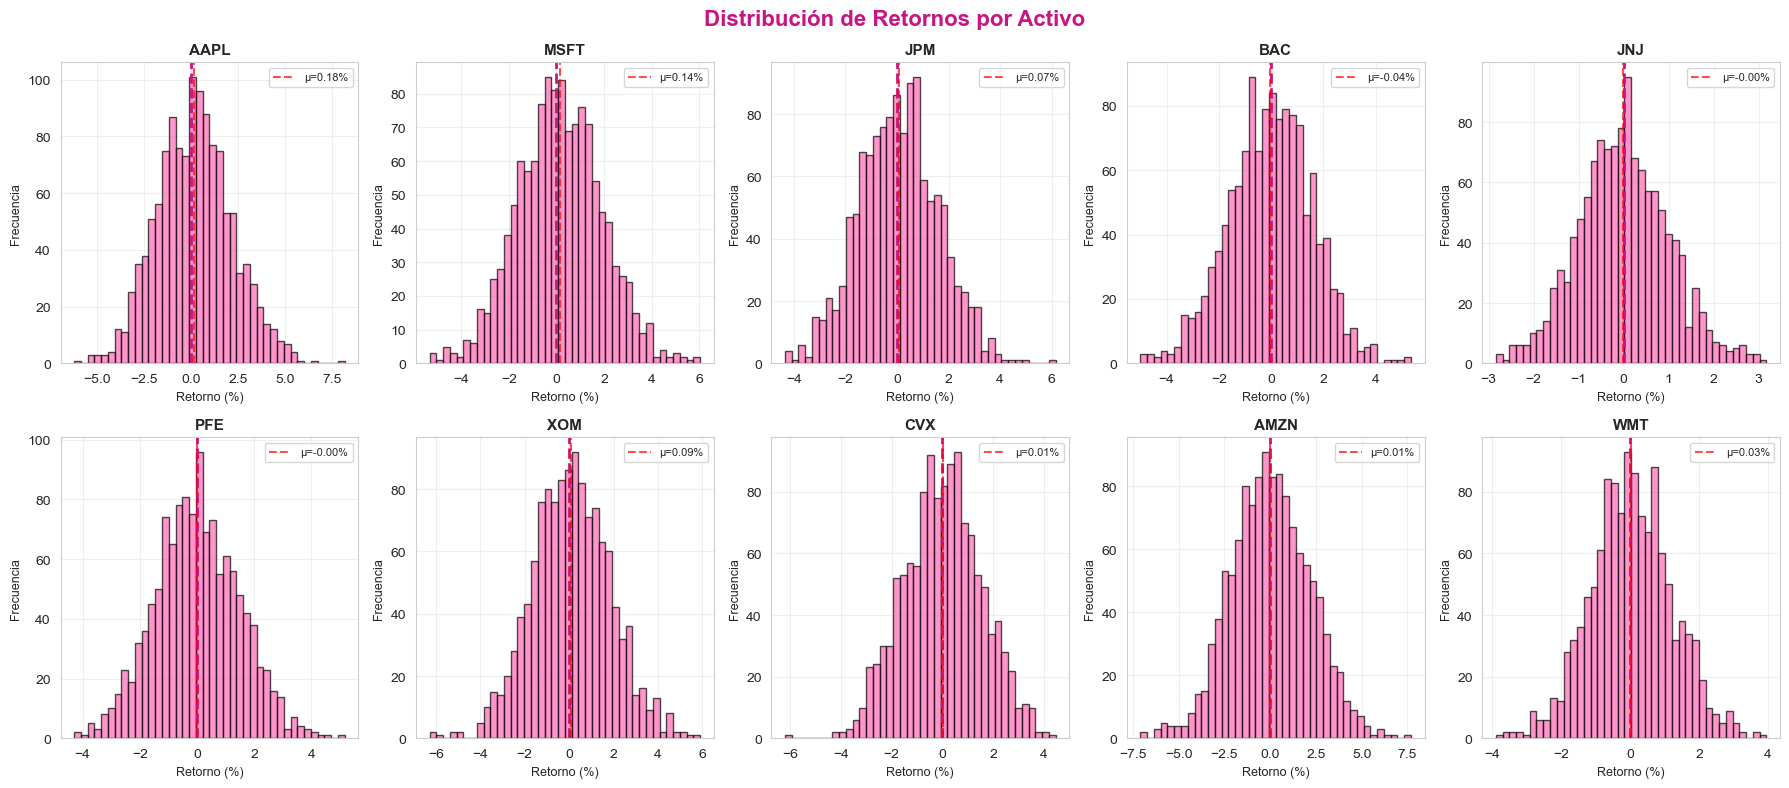

In [16]:
# Histogramas individuales
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, ticker in enumerate(returns.columns):
    data = returns[ticker] * 100
    
    axes[idx].hist(data, bins=40, color=PINK_COLOR, alpha=0.7, edgecolor='black')
    axes[idx].axvline(x=0, color=DARK_PINK, linestyle='--', linewidth=2)
    axes[idx].axvline(x=data.mean(), color='red', linestyle='--', linewidth=1.5, alpha=0.7,
                     label=f'μ={data.mean():.2f}%')
    
    axes[idx].set_title(f'{ticker}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('Retorno (%)', fontsize=9)
    axes[idx].set_ylabel('Frecuencia', fontsize=9)
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Distribución de Retornos por Activo', fontsize=16, fontweight='bold', color=DARK_PINK)
plt.tight_layout()
plt.show()

### Relación entre Variables y la Variable Objetivo

Analizamos cómo se relacionan los retornos de cada activo con el portafolio.

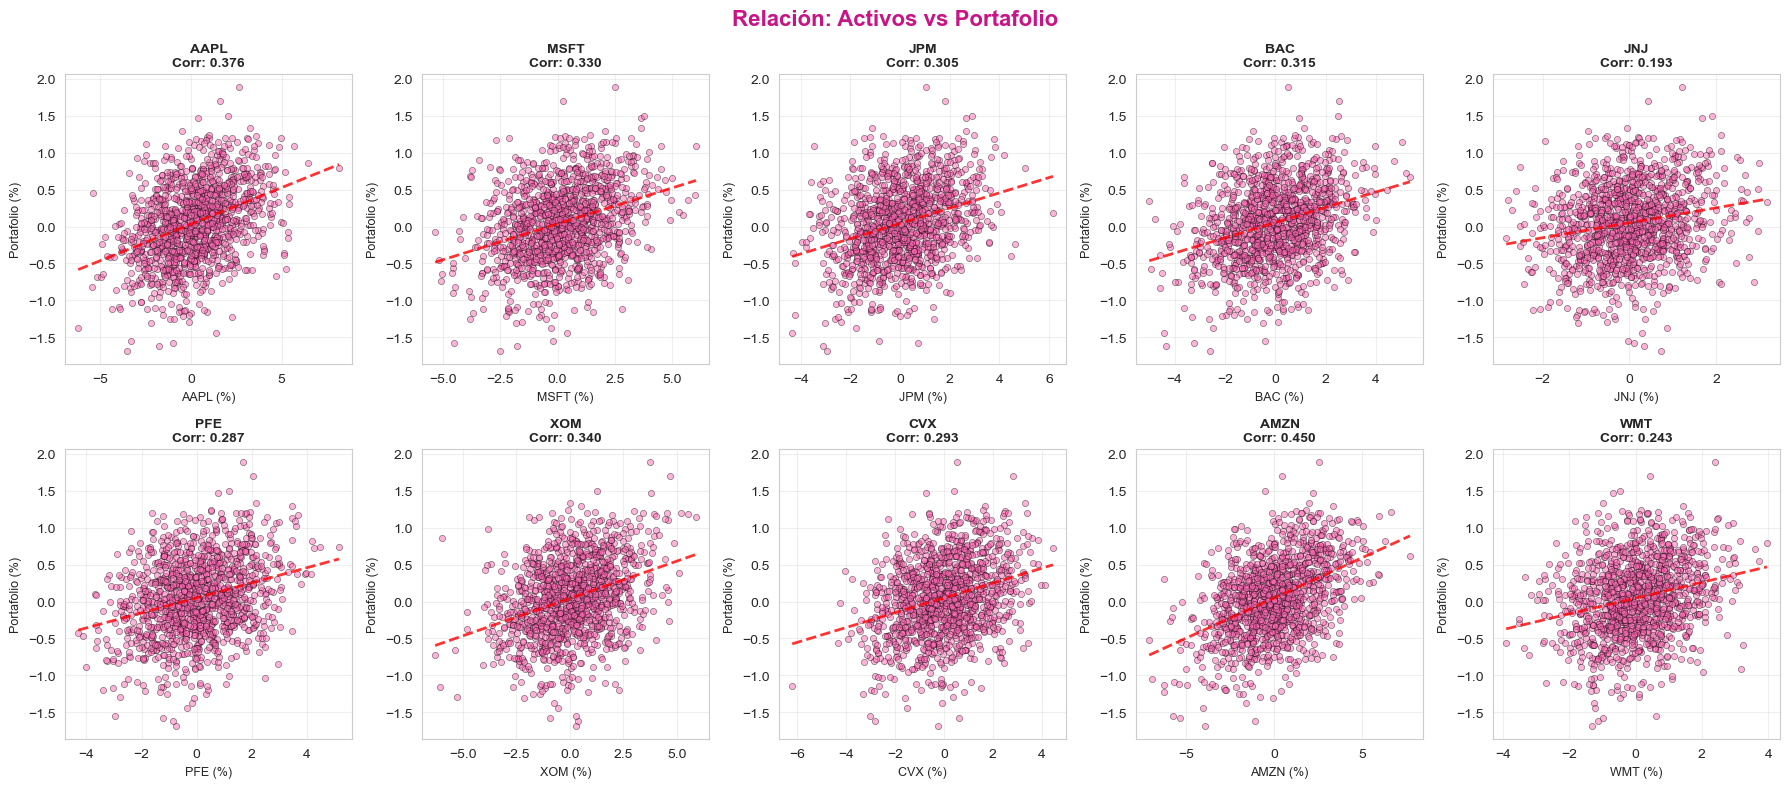

In [18]:
# Scatter plots vs portafolio
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, ticker in enumerate(returns.columns):
    axes[idx].scatter(returns[ticker] * 100, portfolio_returns * 100, 
                     alpha=0.5, s=20, color=PINK_COLOR, edgecolors='black', linewidths=0.5)
    
    # Línea de tendencia
    z = np.polyfit(returns[ticker], portfolio_returns, 1)
    p = np.poly1d(z)
    x_line = np.linspace(returns[ticker].min(), returns[ticker].max(), 100)
    axes[idx].plot(x_line * 100, p(x_line) * 100, "r--", linewidth=2, alpha=0.8)
    
    # Correlación
    corr = returns[ticker].corr(portfolio_returns)
    
    axes[idx].set_xlabel(f'{ticker} (%)', fontsize=9)
    axes[idx].set_ylabel('Portafolio (%)', fontsize=9)
    axes[idx].set_title(f'{ticker}\nCorr: {corr:.3f}', fontsize=10, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Relación: Activos vs Portafolio', fontsize=16, fontweight='bold', color=DARK_PINK)
plt.tight_layout()
plt.show()

### Análisis de Correlación

La correlación entre activos es fundamental para entender la diversificación del portafolio.

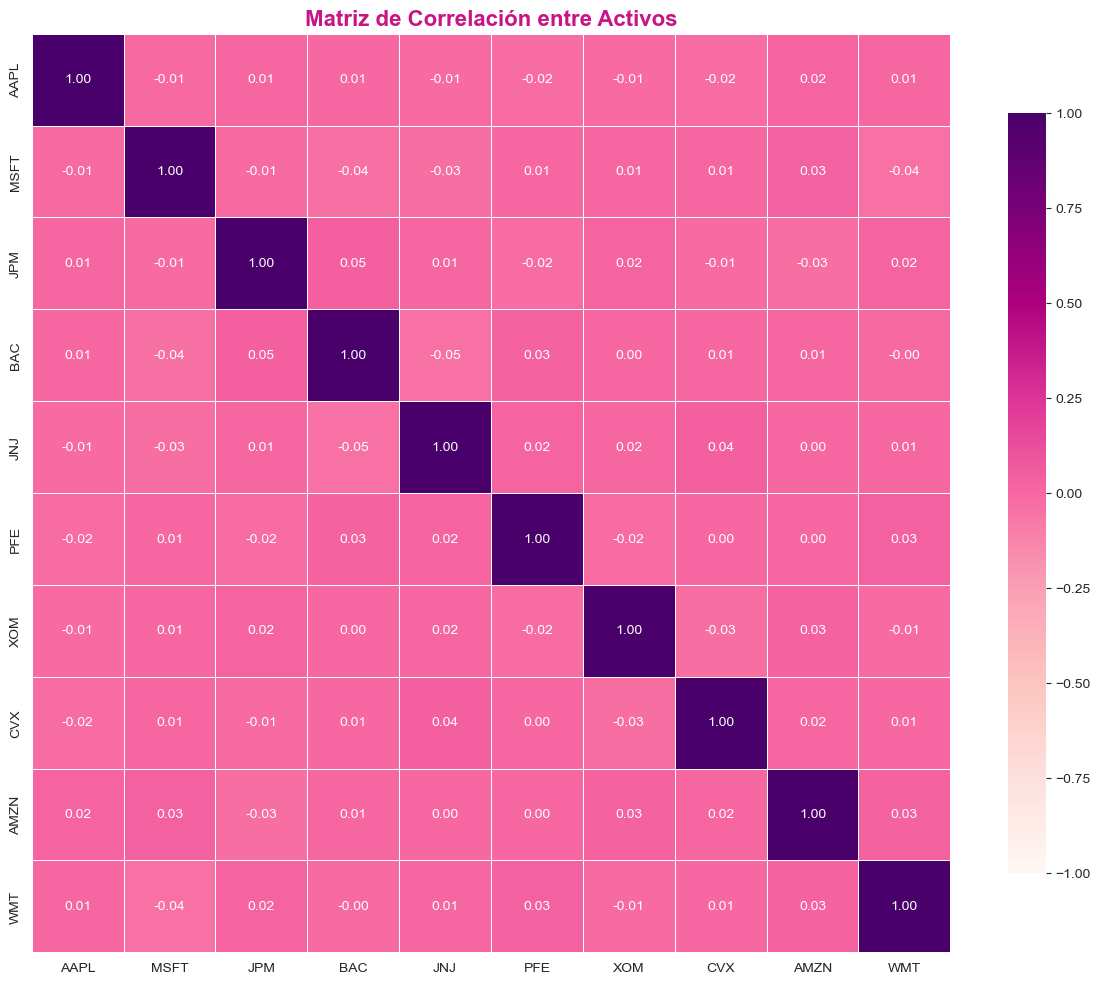


PARES CON MAYOR CORRELACIÓN:
   1. BAC - JNJ: -0.0465
   2. JPM - BAC: 0.0463
   3. MSFT - WMT: -0.0406
   4. JNJ - CVX: 0.0400
   5. MSFT - BAC: -0.0359
   6. MSFT - AMZN: 0.0329
   7. PFE - WMT: 0.0321
   8. BAC - PFE: 0.0297
   9. XOM - AMZN: 0.0290
  10. XOM - CVX: -0.0285

PARES CON MENOR CORRELACIÓN:
   1. MSFT - PFE: 0.0069
   2. MSFT - XOM: 0.0068
   3. BAC - CVX: 0.0061
   4. AAPL - MSFT: -0.0057
   5. CVX - WMT: 0.0056
   6. PFE - AMZN: 0.0047
   7. BAC - XOM: 0.0042
   8. JNJ - AMZN: 0.0042
   9. PFE - CVX: 0.0042
  10. BAC - WMT: -0.0039


In [20]:
correlation_matrix = returns.corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='RdPu', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1, center=0)
ax.set_title('Matriz de Correlación entre Activos', fontsize=16, fontweight='bold', color=DARK_PINK)
plt.tight_layout()
plt.show()

print("\nPARES CON MAYOR CORRELACIÓN:")
print("=" * 60)
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((
            correlation_matrix.columns[i],
            correlation_matrix.columns[j],
            correlation_matrix.iloc[i, j]
        ))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for i, (t1, t2, corr) in enumerate(corr_pairs_sorted[:10], 1):
    print(f"  {i:2d}. {t1} - {t2}: {corr:.4f}")

print("\nPARES CON MENOR CORRELACIÓN:")
for i, (t1, t2, corr) in enumerate(corr_pairs_sorted[-10:], 1):
    print(f"  {i:2d}. {t1} - {t2}: {corr:.4f}")

### Boxplots: Variables Numéricas vs Variable Objetivo

Los boxplots nos permiten identificar outliers y comparar distribuciones.

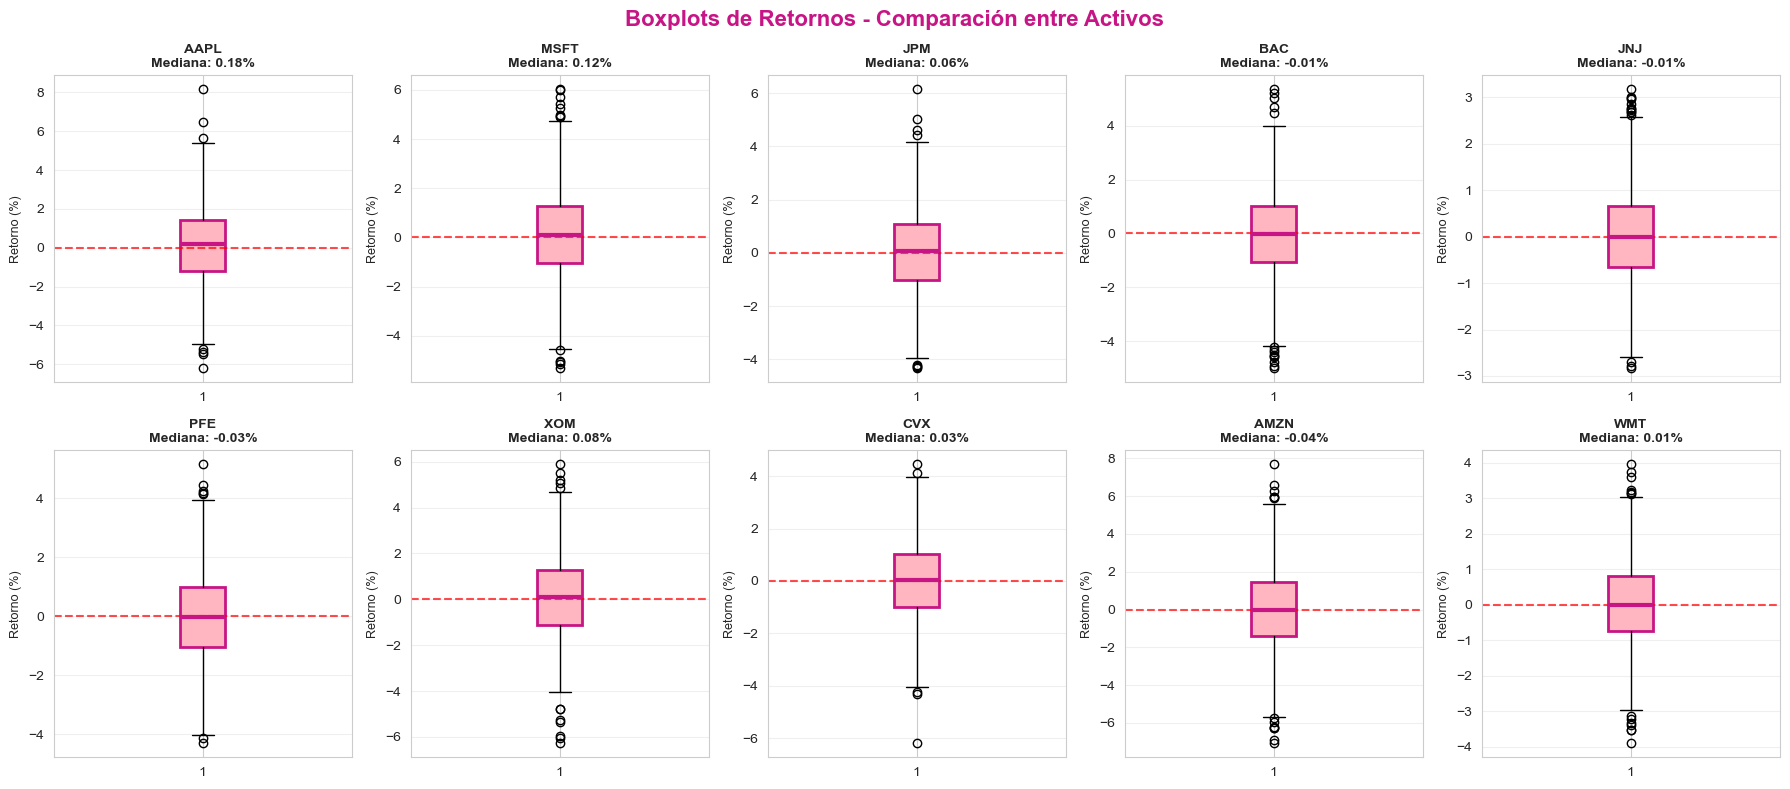

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for idx, ticker in enumerate(returns.columns):
    data = returns[ticker] * 100
    bp = axes[idx].boxplot(data, patch_artist=True, vert=True)
    
    bp['boxes'][0].set_facecolor(LIGHT_PINK)
    bp['boxes'][0].set_edgecolor(DARK_PINK)
    bp['boxes'][0].set_linewidth(2)
    bp['medians'][0].set_color(DARK_PINK)
    bp['medians'][0].set_linewidth(3)
    
    axes[idx].axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Estadísticas
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    median = np.median(data)
    
    axes[idx].set_title(f'{ticker}\nMediana: {median:.2f}%', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Retorno (%)', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Boxplots de Retornos - Comparación entre Activos', 
            fontsize=16, fontweight='bold', color=DARK_PINK)
plt.tight_layout()
plt.show()

### Detección de Outliers

Utilizamos el método IQR (Rango Intercuartílico) para detectar valores atípicos en cada activo.

DETECCIÓN DE OUTLIERS (Método IQR)

AAPL:
  Outliers detectados: 7 (0.56%)
  Límite inferior: -5.1568%
  Límite superior: 5.4222%
  Outlier más extremo: 8.1597%

MSFT:
  Outliers detectados: 13 (1.03%)
  Límite inferior: -4.5845%
  Límite superior: 4.8238%
  Outlier más extremo: 6.0268%

JPM:
  Outliers detectados: 8 (0.64%)
  Límite inferior: -4.1907%
  Límite superior: 4.2476%
  Outlier más extremo: 6.1523%

BAC:
  Outliers detectados: 14 (1.11%)
  Límite inferior: -4.1810%
  Límite superior: 4.1502%
  Outlier más extremo: 5.3495%

JNJ:
  Outliers detectados: 14 (1.11%)
  Límite inferior: -2.6166%
  Límite superior: 2.6113%
  Outlier más extremo: 3.1732%

PFE:
  Outliers detectados: 7 (0.56%)
  Límite inferior: -4.0724%
  Límite superior: 4.0609%
  Outlier más extremo: 5.1608%

XOM:
  Outliers detectados: 12 (0.95%)
  Límite inferior: -4.6559%
  Límite superior: 4.8295%
  Outlier más extremo: 6.2789%

CVX:
  Outliers detectados: 5 (0.40%)
  Límite inferior: -4.0591%
  Límite superior

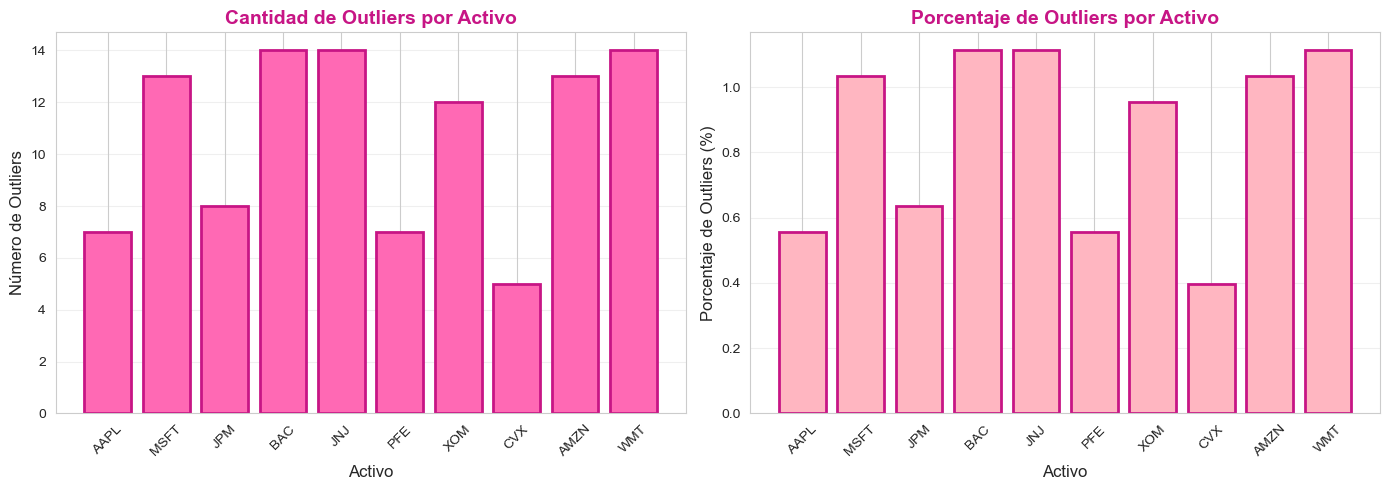

In [24]:
print("DETECCIÓN DE OUTLIERS (Método IQR)")
print("=" * 80)

outliers_summary = {}

for ticker in returns.columns:
    data = returns[ticker]
    
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outliers_count = len(outliers)
    outliers_pct = (outliers_count / len(data)) * 100
    
    outliers_summary[ticker] = {
        'count': outliers_count,
        'percentage': outliers_pct,
        'lower_bound': lower_bound * 100,
        'upper_bound': upper_bound * 100
    }
    
    print(f"\n{ticker}:")
    print(f"  Outliers detectados: {outliers_count} ({outliers_pct:.2f}%)")
    print(f"  Límite inferior: {lower_bound*100:.4f}%")
    print(f"  Límite superior: {upper_bound*100:.4f}%")
    
    if outliers_count > 0:
        print(f"  Outlier más extremo: {outliers.abs().max()*100:.4f}%")

# Visualización
outliers_counts = [info['count'] for info in outliers_summary.values()]
outliers_pcts = [info['percentage'] for info in outliers_summary.values()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(outliers_summary.keys(), outliers_counts, color=PINK_COLOR, edgecolor=DARK_PINK, linewidth=2)
axes[0].set_xlabel('Activo', fontsize=12)
axes[0].set_ylabel('Número de Outliers', fontsize=12)
axes[0].set_title('Cantidad de Outliers por Activo', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(outliers_summary.keys(), outliers_pcts, color=LIGHT_PINK, edgecolor=DARK_PINK, linewidth=2)
axes[1].set_xlabel('Activo', fontsize=12)
axes[1].set_ylabel('Porcentaje de Outliers (%)', fontsize=12)
axes[1].set_title('Porcentaje de Outliers por Activo', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Tratamiento de Valores Faltantes

Verificamos la existencia de valores nulos y procedemos según sea necesario.

In [26]:
print("ANÁLISIS DE VALORES FALTANTES")
print("=" * 80)

# Verificamos en precios
print("\nValores nulos en precios:")
null_prices = close_prices.isnull().sum()
print(null_prices)

# Verificamos en retornos
print("\nValores nulos en retornos:")
null_returns = returns.isnull().sum()
print(null_returns)

total_nulls = null_returns.sum()
print(f"\nTotal de valores nulos en retornos: {total_nulls}")

if total_nulls > 0:
    print("\nAcción: Eliminar filas con valores nulos")
    returns_clean = returns.dropna()
    print(f"Filas eliminadas: {len(returns) - len(returns_clean)}")
    returns = returns_clean
else:
    print("\n No hay valores nulos en el dataset")

print(f"\nDataset final de retornos: {returns.shape}")

ANÁLISIS DE VALORES FALTANTES

Valores nulos en precios:
AAPL    0
MSFT    0
JPM     0
BAC     0
JNJ     0
PFE     0
XOM     0
CVX     0
AMZN    0
WMT     0
dtype: int64

Valores nulos en retornos:
AAPL    0
MSFT    0
JPM     0
BAC     0
JNJ     0
PFE     0
XOM     0
CVX     0
AMZN    0
WMT     0
dtype: int64

Total de valores nulos en retornos: 0

✓ No hay valores nulos en el dataset

Dataset final de retornos: (1259, 10)


### Tratamiento de Outliers Extremos

Decidimos mantener los outliers porque en datos financieros representan eventos reales del mercado (crisis, burbujas, etc.). Eliminarlos sesgaria el modelo.

In [28]:
print("DECISIÓN SOBRE OUTLIERS")
print("=" * 80)

print("\nEn datos financieros, los outliers son eventos legítimos:")
print("  • Caídas del mercado (crashes)")
print("  • Rallies alcistas")
print("  • Eventos macroeconómicos")
print("  • Anuncios corporativos")

print("\n DECISIÓN: Mantener todos los outliers")
print("  Los modelos de ensemble (Random Forest, Gradient Boosting)")
print("  son robustos ante outliers y pueden aprender de estos eventos extremos.")

print(f"\nDataset completo mantenido: {returns.shape}")

DECISIÓN SOBRE OUTLIERS

En datos financieros, los outliers son eventos legítimos:
  • Caídas del mercado (crashes)
  • Rallies alcistas
  • Eventos macroeconómicos
  • Anuncios corporativos

✓ DECISIÓN: Mantener todos los outliers
  Los modelos de ensemble (Random Forest, Gradient Boosting)
  son robustos ante outliers y pueden aprender de estos eventos extremos.

Dataset completo mantenido: (1259, 10)


## Ingeniería de Características

Creamos indicadores técnicos derivados de los precios históricos. Estos servirán como variables predictoras en nuestros modelos.

In [30]:
def calculate_rsi(returns, period=14):
    if len(returns) < period:
        return 50
    gains = returns[returns > 0].sum()
    losses = abs(returns[returns < 0].sum())
    if losses == 0:
        return 100
    rs = gains / losses
    rsi = 100 - (100 / (1 + rs))
    return rsi

def create_features(prices_df, returns_df, lookback=30):
    features_list = []
    target_list = []
    dates_list = []
    
    for ticker in prices_df.columns:
        price_data = prices_df[ticker]
        return_data = returns_df[ticker]
        
        for i in range(lookback, len(price_data) - 1):
            price_window = price_data.iloc[i-lookback:i]
            return_window = return_data.iloc[i-lookback:i]
            
            features = {
                'mean_return': return_window.mean(),
                'std_return': return_window.std(),
                'min_return': return_window.min(),
                'max_return': return_window.max(),
                'sma_5': price_window.iloc[-5:].mean() / price_window.iloc[-1],
                'sma_10': price_window.iloc[-10:].mean() / price_window.iloc[-1],
                'sma_20': price_window.iloc[-20:].mean() / price_window.iloc[-1],
                'momentum_5': (price_window.iloc[-1] - price_window.iloc[-5]) / price_window.iloc[-5],
                'momentum_10': (price_window.iloc[-1] - price_window.iloc[-10]) / price_window.iloc[-10],
                'volatility_5': return_window.iloc[-5:].std(),
                'volatility_10': return_window.iloc[-10:].std(),
                'price_range': (price_window.max() - price_window.min()) / price_window.mean(),
                'trend': (price_window.iloc[-1] - price_window.iloc[0]) / price_window.iloc[0],
                'rsi': calculate_rsi(return_window, period=14)
            }
            
            target = return_data.iloc[i]
            
            features_list.append(features)
            target_list.append(target)
            dates_list.append(price_data.index[i])
    
    return pd.DataFrame(features_list), pd.Series(target_list, name='target_return'), pd.Series(dates_list, name='date')

print("Creando características...")
X, y, dates = create_features(close_prices, returns, lookback=30)

print(f" Dataset de características: {X.shape}")
print(f" Variable objetivo: {y.shape}")
print(f"\nCaracterísticas creadas:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

Creando características...
✓ Dataset de características: (12290, 14)
✓ Variable objetivo: (12290,)

Características creadas:
   1. mean_return
   2. std_return
   3. min_return
   4. max_return
   5. sma_5
   6. sma_10
   7. sma_20
   8. momentum_5
   9. momentum_10
  10. volatility_5
  11. volatility_10
  12. price_range
  13. trend
  14. rsi


### Análisis de Nuevas Características

Examinamos las características creadas para entender su distribución.

In [32]:
print("Estadísticas de las características creadas:")
X.describe()

Estadísticas de las características creadas:


,mean_return,std_return,min_return,max_return,sma_5,sma_10,sma_20,momentum_5,momentum_10,volatility_5,volatility_10,price_range,trend,rsi
count,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000,12290.000000
mean,0.000493,0.015836,-0.032119,0.033493,0.999501,0.998907,0.997779,0.002111,0.004646,0.014938,0.015523,0.122443,0.014567,51.675267
std,0.003053,0.003828,0.010500,0.010910,0.018250,0.028110,0.041105,0.033488,0.050335,0.006305,0.004870,0.051307,0.091428,11.573097
min,-0.012915,0.006444,-0.070819,0.010967,0.927174,0.869616,0.808862,-0.135369,-0.224854,0.000374,0.003899,0.029390,-0.319582,15.046788
25%,-0.001486,0.013299,-0.037630,0.025771,0.987628,0.981063,0.971848,-0.019602,-0.027711,0.010321,0.011998,0.084751,-0.046280,43.825689
50%,0.000409,0.015651,-0.030390,0.031732,0.999355,0.998579,0.997046,0.001274,0.002861,0.014171,0.015090,0.114467,0.008963,51.714882
75%,0.002430,0.018250,-0.025185,0.039675,1.011135,1.016110,1.023113,0.023176,0.035160,0.018656,0.018557,0.148303,0.070042,59.819591
max,0.013051,0.028851,-0.009977,0.081597,1.081021,1.140140,1.229640,0.150265,0.311662,0.049183,0.035974,0.401210,0.461200,89.436190



Características ordenadas por correlación con target:
          Feature  Correlación con Target
1      std_return                0.016669
2      min_return               -0.016363
3      max_return                0.015176
8     momentum_10               -0.013075
9    volatility_5                0.012520
5          sma_10                0.011205
0     mean_return                0.010315
4           sma_5                0.010218
10  volatility_10                0.009977
13            rsi                0.008963
6          sma_20                0.008776
7      momentum_5               -0.006380
11    price_range                0.003294
12          trend                0.002469


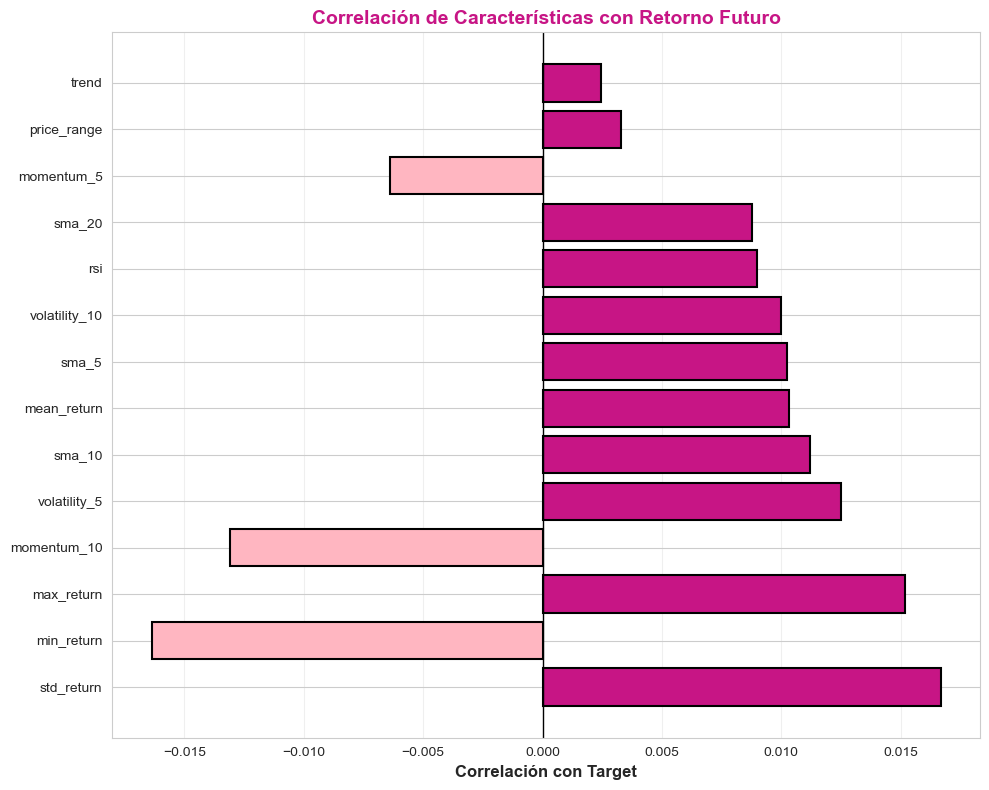

In [33]:
# Correlación de características con el objetivo
feature_target_corr = pd.DataFrame({
    'Feature': X.columns,
    'Correlación con Target': [X[col].corr(y) for col in X.columns]
}).sort_values('Correlación con Target', key=abs, ascending=False)

print("\nCaracterísticas ordenadas por correlación con target:")
print(feature_target_corr)

# Visualizar
fig, ax = plt.subplots(figsize=(10, 8))
colors = [DARK_PINK if corr > 0 else LIGHT_PINK for corr in feature_target_corr['Correlación con Target']]
ax.barh(feature_target_corr['Feature'], feature_target_corr['Correlación con Target'], 
        color=colors, edgecolor='black', linewidth=1.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Correlación con Target', fontsize=12, fontweight='bold')
ax.set_title('Correlación de Características con Retorno Futuro', 
            fontsize=14, fontweight='bold', color=DARK_PINK)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## Preparación de Datos para Modelado

### División de Datos: Entrenamiento y Prueba

Usamos división temporal (80/20) sin aleatorización para respetar el orden cronológico.

In [35]:
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Conjunto de entrenamiento: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Conjunto de prueba: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Datos normalizados con StandardScaler")

Conjunto de entrenamiento: 9832 muestras (80.0%)
Conjunto de prueba: 2458 muestras (20.0%)

✓ Datos normalizados con StandardScaler


## Construcción y Evaluación de Modelos

Entrenaremos y evaluaremos **10 algoritmos diferentes** de regresión para comparar su desempeño.

### 1. Regresión Lineal

Modelo baseline simple que asume relación lineal entre características y objetivo.

In [38]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr_test = lr_model.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
mae_lr = mean_absolute_error(y_test, y_pred_lr_test)
r2_lr = r2_score(y_test, y_pred_lr_test)

print("REGRESIÓN LINEAL")
print("=" * 60)
print(f"  RMSE: {rmse_lr*100:.3f}%")
print(f"  MAE:  {mae_lr*100:.3f}%")
print(f"  R²:   {r2_lr:.4f}")

REGRESIÓN LINEAL
  RMSE: 1.738%
  MAE:  1.327%
  R²:   0.0007


### 2. Ridge Regression

Añade regularización L2 para prevenir overfitting.

In [40]:
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge_test = ridge_model.predict(X_test_scaled)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))
mae_ridge = mean_absolute_error(y_test, y_pred_ridge_test)
r2_ridge = r2_score(y_test, y_pred_ridge_test)

print("RIDGE REGRESSION")
print("=" * 60)
print(f"  RMSE: {rmse_ridge*100:.3f}%")
print(f"  MAE:  {mae_ridge*100:.3f}%")
print(f"  R²:   {r2_ridge:.4f}")

RIDGE REGRESSION
  RMSE: 1.738%
  MAE:  1.327%
  R²:   0.0007


### 3. Lasso Regression

Usa regularización L1 que puede reducir coeficientes a cero.

In [42]:
lasso_model = Lasso(alpha=0.001, random_state=42, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso_test = lasso_model.predict(X_test_scaled)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso_test))
mae_lasso = mean_absolute_error(y_test, y_pred_lasso_test)
r2_lasso = r2_score(y_test, y_pred_lasso_test)

print("LASSO REGRESSION")
print("=" * 60)
print(f"  RMSE: {rmse_lasso*100:.3f}%")
print(f"  MAE:  {mae_lasso*100:.3f}%")
print(f"  R²:   {r2_lasso:.4f}")
print(f"  Features eliminadas: {np.sum(lasso_model.coef_ == 0)}/{len(X.columns)}")

LASSO REGRESSION
  RMSE: 1.739%
  MAE:  1.330%
  R²:   -0.0005
  Features eliminadas: 14/14


### 4. ElasticNet

Combina regularización L1 y L2.

In [44]:
from sklearn.linear_model import ElasticNet

elastic_model = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42, max_iter=10000)
elastic_model.fit(X_train_scaled, y_train)
y_pred_elastic_test = elastic_model.predict(X_test_scaled)

rmse_elastic = np.sqrt(mean_squared_error(y_test, y_pred_elastic_test))
mae_elastic = mean_absolute_error(y_test, y_pred_elastic_test)
r2_elastic = r2_score(y_test, y_pred_elastic_test)

print("ELASTICNET")
print("=" * 60)
print(f"  RMSE: {rmse_elastic*100:.3f}%")
print(f"  MAE:  {mae_elastic*100:.3f}%")
print(f"  R²:   {r2_elastic:.4f}")

ELASTICNET
  RMSE: 1.739%
  MAE:  1.330%
  R²:   -0.0005


### 5. Support Vector Regression

Usa kernel RBF para capturar relaciones no lineales.

In [46]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.01)
print("Entrenando SVR...")
svr_model.fit(X_train_scaled, y_train)
y_pred_svr_test = svr_model.predict(X_test_scaled)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr_test))
mae_svr = mean_absolute_error(y_test, y_pred_svr_test)
r2_svr = r2_score(y_test, y_pred_svr_test)

print("SUPPORT VECTOR REGRESSION")
print("=" * 60)
print(f"  RMSE: {rmse_svr*100:.3f}%")
print(f"  MAE:  {mae_svr*100:.3f}%")
print(f"  R²:   {r2_svr:.4f}")

Entrenando SVR...
SUPPORT VECTOR REGRESSION
  RMSE: 2.147%
  MAE:  1.608%
  R²:   -0.5251


### 6. K-Nearest Neighbors

Predice basándose en los k vecinos más cercanos.

In [48]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_model.fit(X_train_scaled, y_train)
y_pred_knn_test = knn_model.predict(X_test_scaled)

rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn_test))
mae_knn = mean_absolute_error(y_test, y_pred_knn_test)
r2_knn = r2_score(y_test, y_pred_knn_test)

print("K-NEAREST NEIGHBORS")
print("=" * 60)
print(f"  RMSE: {rmse_knn*100:.3f}%")
print(f"  MAE:  {mae_knn*100:.3f}%")
print(f"  R²:   {r2_knn:.4f}")

K-NEAREST NEIGHBORS
  RMSE: 1.877%
  MAE:  1.451%
  R²:   -0.1653


### 7. Decision Tree

Árbol de decisión individual.

In [50]:
dt_model = DecisionTreeRegressor(max_depth=10, min_samples_split=5, random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt_test = dt_model.predict(X_test_scaled)

rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt_test))
mae_dt = mean_absolute_error(y_test, y_pred_dt_test)
r2_dt = r2_score(y_test, y_pred_dt_test)

print("DECISION TREE")
print("=" * 60)
print(f"  RMSE: {rmse_dt*100:.3f}%")
print(f"  MAE:  {mae_dt*100:.3f}%")
print(f"  R²:   {r2_dt:.4f}")

DECISION TREE
  RMSE: 1.928%
  MAE:  1.454%
  R²:   -0.2303


### 8. Extra Trees

Similar a Random Forest pero con mayor aleatoriedad.

In [52]:
et_model = ExtraTreesRegressor(n_estimators=200, max_depth=15, min_samples_split=5, 
                                random_state=42, n_jobs=-1)
et_model.fit(X_train_scaled, y_train)
y_pred_et_test = et_model.predict(X_test_scaled)

rmse_et = np.sqrt(mean_squared_error(y_test, y_pred_et_test))
mae_et = mean_absolute_error(y_test, y_pred_et_test)
r2_et = r2_score(y_test, y_pred_et_test)

print("EXTRA TREES")
print("=" * 60)
print(f"  RMSE: {rmse_et*100:.3f}%")
print(f"  MAE:  {mae_et*100:.3f}%")
print(f"  R²:   {r2_et:.4f}")

EXTRA TREES
  RMSE: 1.752%
  MAE:  1.343%
  R²:   -0.0161


### 9. Random Forest

Ensemble de múltiples árboles con promediado.

In [54]:
rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5,
                                 min_samples_leaf=2, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf_test = rf_model.predict(X_test_scaled)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
mae_rf = mean_absolute_error(y_test, y_pred_rf_test)
r2_rf = r2_score(y_test, y_pred_rf_test)

print("RANDOM FOREST")
print("=" * 60)
print(f"  RMSE: {rmse_rf*100:.3f}%")
print(f"  MAE:  {mae_rf*100:.3f}%")
print(f"  R²:   {r2_rf:.4f}")

RANDOM FOREST
  RMSE: 1.750%
  MAE:  1.341%
  R²:   -0.0137


### 10. Gradient Boosting

Construcción secuencial de árboles.

In [56]:
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, max_depth=5,
                                      min_samples_split=5, subsample=0.8, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb_test = gb_model.predict(X_test_scaled)

rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb_test))
mae_gb = mean_absolute_error(y_test, y_pred_gb_test)
r2_gb = r2_score(y_test, y_pred_gb_test)

print("GRADIENT BOOSTING")
print("=" * 60)
print(f"  RMSE: {rmse_gb*100:.3f}%")
print(f"  MAE:  {mae_gb*100:.3f}%")
print(f"  R²:   {r2_gb:.4f}")

GRADIENT BOOSTING
  RMSE: 1.773%
  MAE:  1.353%
  R²:   -0.0408


## Comparación de Modelos

Comparamos el desempeño de los 10 algoritmos entrenados.

In [58]:
# Creamos tabla comparativa
comparison_data = {
    'Modelo': ['Linear Reg', 'Ridge', 'Lasso', 'ElasticNet', 'SVR', 
               'KNN', 'Decision Tree', 'Extra Trees', 'Random Forest', 'Gradient Boosting'],
    'RMSE (%)': [f"{rmse_lr*100:.3f}", f"{rmse_ridge*100:.3f}", f"{rmse_lasso*100:.3f}",
                 f"{rmse_elastic*100:.3f}", f"{rmse_svr*100:.3f}", f"{rmse_knn*100:.3f}",
                 f"{rmse_dt*100:.3f}", f"{rmse_et*100:.3f}", f"{rmse_rf*100:.3f}", 
                 f"{rmse_gb*100:.3f}"],
    'MAE (%)': [f"{mae_lr*100:.3f}", f"{mae_ridge*100:.3f}", f"{mae_lasso*100:.3f}",
                f"{mae_elastic*100:.3f}", f"{mae_svr*100:.3f}", f"{mae_knn*100:.3f}",
                f"{mae_dt*100:.3f}", f"{mae_et*100:.3f}", f"{mae_rf*100:.3f}", 
                f"{mae_gb*100:.3f}"],
    'R²': [f"{r2_lr:.4f}", f"{r2_ridge:.4f}", f"{r2_lasso:.4f}",
           f"{r2_elastic:.4f}", f"{r2_svr:.4f}", f"{r2_knn:.4f}",
           f"{r2_dt:.4f}", f"{r2_et:.4f}", f"{r2_rf:.4f}", 
           f"{r2_gb:.4f}"]
}

comparison_df = pd.DataFrame(comparison_data)
print("COMPARACIÓN DE TODOS LOS MODELOS")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Identificamos los top 3
rmse_values = [rmse_lr, rmse_ridge, rmse_lasso, rmse_elastic, rmse_svr, rmse_knn,
               rmse_dt, rmse_et, rmse_rf, rmse_gb]
model_names = comparison_data['Modelo']
sorted_idx = np.argsort(rmse_values)

print("\n" + "=" * 80)
print("TOP 3 MODELOS (menor RMSE):")
for i in range(3):
    idx = sorted_idx[i]
    print(f"  {i+1}. {model_names[idx]}: RMSE = {rmse_values[idx]*100:.3f}%")
print("=" * 80)

COMPARACIÓN DE TODOS LOS MODELOS
           Modelo RMSE (%) MAE (%)      R²
       Linear Reg    1.738   1.327  0.0007
            Ridge    1.738   1.327  0.0007
            Lasso    1.739   1.330 -0.0005
       ElasticNet    1.739   1.330 -0.0005
              SVR    2.147   1.608 -0.5251
              KNN    1.877   1.451 -0.1653
    Decision Tree    1.928   1.454 -0.2303
      Extra Trees    1.752   1.343 -0.0161
    Random Forest    1.750   1.341 -0.0137
Gradient Boosting    1.773   1.353 -0.0408

TOP 3 MODELOS (menor RMSE):
  1. Linear Reg: RMSE = 1.738%
  2. Ridge: RMSE = 1.738%
  3. Lasso: RMSE = 1.739%


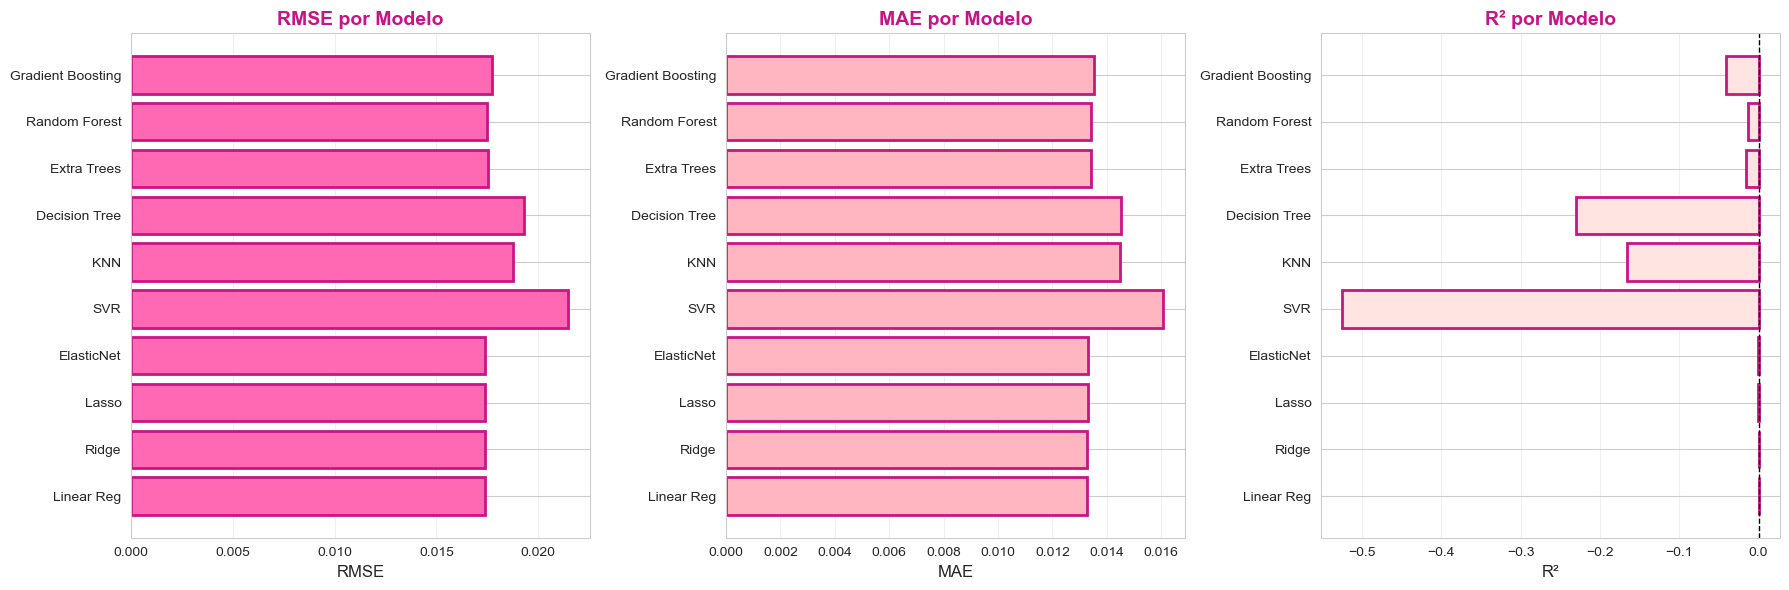

In [59]:
# Gráfico comparativo
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RMSE
axes[0].barh(comparison_data['Modelo'], rmse_values, color=PINK_COLOR, edgecolor=DARK_PINK, linewidth=2)
axes[0].set_xlabel('RMSE', fontsize=12)
axes[0].set_title('RMSE por Modelo', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[0].grid(True, alpha=0.3, axis='x')

# MAE
mae_values = [mae_lr, mae_ridge, mae_lasso, mae_elastic, mae_svr, mae_knn,
              mae_dt, mae_et, mae_rf, mae_gb]
axes[1].barh(comparison_data['Modelo'], mae_values, color=LIGHT_PINK, edgecolor=DARK_PINK, linewidth=2)
axes[1].set_xlabel('MAE', fontsize=12)
axes[1].set_title('MAE por Modelo', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[1].grid(True, alpha=0.3, axis='x')

# R²
r2_values = [r2_lr, r2_ridge, r2_lasso, r2_elastic, r2_svr, r2_knn,
             r2_dt, r2_et, r2_rf, r2_gb]
colors_r2 = [PINK_COLOR if r2 > 0 else '#FFE4E1' for r2 in r2_values]
axes[2].barh(comparison_data['Modelo'], r2_values, color=colors_r2, edgecolor=DARK_PINK, linewidth=2)
axes[2].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[2].set_xlabel('R²', fontsize=12)
axes[2].set_title('R² por Modelo', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[2].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Evaluación Detallada del Mejor Modelo

Realizamos un análisis profundo del modelo con mejor desempeño.

In [61]:
# Identificamos el mejor modelo
best_idx = sorted_idx[0]
best_model_name = model_names[best_idx]

print(f"MODELO SELECCIONADO: {best_model_name}")
print("=" * 80)

# Usaremos el mejor modelo para análisis detallado
if 'Random' in best_model_name or 'Extra' in best_model_name or 'Gradient' in best_model_name:
    if 'Random' in best_model_name:
        best_model = rf_model
        y_pred_best = y_pred_rf_test
    elif 'Extra' in best_model_name:
        best_model = et_model
        y_pred_best = y_pred_et_test
    else:
        best_model = gb_model
        y_pred_best = y_pred_gb_test
    
    # Importancia de características
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 características más importantes:")
    print(feature_importance.head(10))
    
    # Gráfico
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = feature_importance.head(10)
    ax.barh(range(len(top_features)), top_features['Importance'], color=PINK_COLOR, edgecolor=DARK_PINK, linewidth=2)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importancia', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 10 Características - {best_model_name}', fontsize=14, fontweight='bold', color=DARK_PINK)
    ax.invert_yaxis()
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("El mejor modelo es lineal. No tiene importancia de características basada en árboles.")
    y_pred_best = y_pred_lr_test if best_idx == 0 else y_pred_ridge_test

MODELO SELECCIONADO: Linear Reg
El mejor modelo es lineal. No tiene importancia de características basada en árboles.


## Validación Cruzada

Evaluamos la robustez del modelo usando Time Series Cross-Validation.

VALIDACIÓN CRUZADA - TIME SERIES SPLIT

Random Forest:
  RMSE CV: 1.548% (+/- 0.183%)
  Folds individuales: ['1.693%', '1.620%', '1.192%', '1.662%', '1.571%']

Gradient Boosting:
  RMSE CV: 1.595% (+/- 0.158%)
  Folds individuales: ['1.753%', '1.666%', '1.298%', '1.678%', '1.579%']


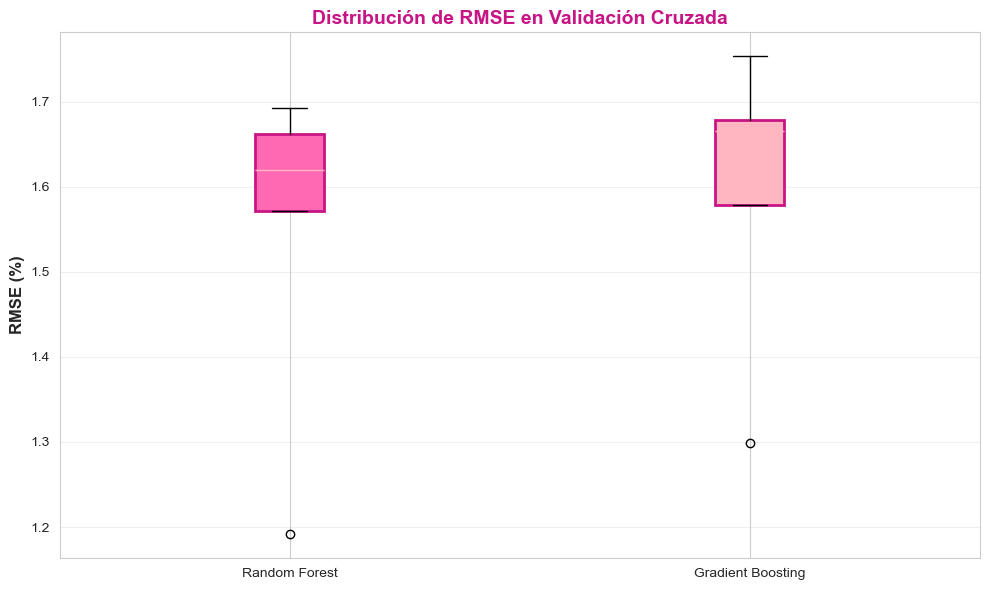

In [63]:
tscv = TimeSeriesSplit(n_splits=5)

print("VALIDACIÓN CRUZADA - TIME SERIES SPLIT")
print("=" * 80)

# Evaluar Random Forest y Gradient Boosting
cv_scores_rf = cross_val_score(rf_model, X_train_scaled, y_train, cv=tscv, 
                                scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse_rf = np.sqrt(-cv_scores_rf)

cv_scores_gb = cross_val_score(gb_model, X_train_scaled, y_train, cv=tscv,
                                scoring='neg_mean_squared_error')
cv_rmse_gb = np.sqrt(-cv_scores_gb)

print(f"\nRandom Forest:")
print(f"  RMSE CV: {cv_rmse_rf.mean()*100:.3f}% (+/- {cv_rmse_rf.std()*100:.3f}%)")
print(f"  Folds individuales: {[f'{x*100:.3f}%' for x in cv_rmse_rf]}")

print(f"\nGradient Boosting:")
print(f"  RMSE CV: {cv_rmse_gb.mean()*100:.3f}% (+/- {cv_rmse_gb.std()*100:.3f}%)")
print(f"  Folds individuales: {[f'{x*100:.3f}%' for x in cv_rmse_gb]}")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
bp = ax.boxplot([cv_rmse_rf*100, cv_rmse_gb*100], 
                labels=['Random Forest', 'Gradient Boosting'], patch_artist=True)

bp['boxes'][0].set_facecolor(PINK_COLOR)
bp['boxes'][1].set_facecolor(LIGHT_PINK)
for box in bp['boxes']:
    box.set_edgecolor(DARK_PINK)
    box.set_linewidth(2)

ax.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax.set_title('Distribución de RMSE en Validación Cruzada', fontsize=14, fontweight='bold', color=DARK_PINK)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## Análisis de Errores

Examinamos los residuos del mejor modelo para identificar patrones.

ESTADÍSTICAS DE RESIDUOS
Media: -0.000434
Mediana: -0.000662
Desv. Std: 0.017375
Mínimo: -0.072693
Máximo: 0.076645
Skewness: -0.0150
Kurtosis: 0.9946


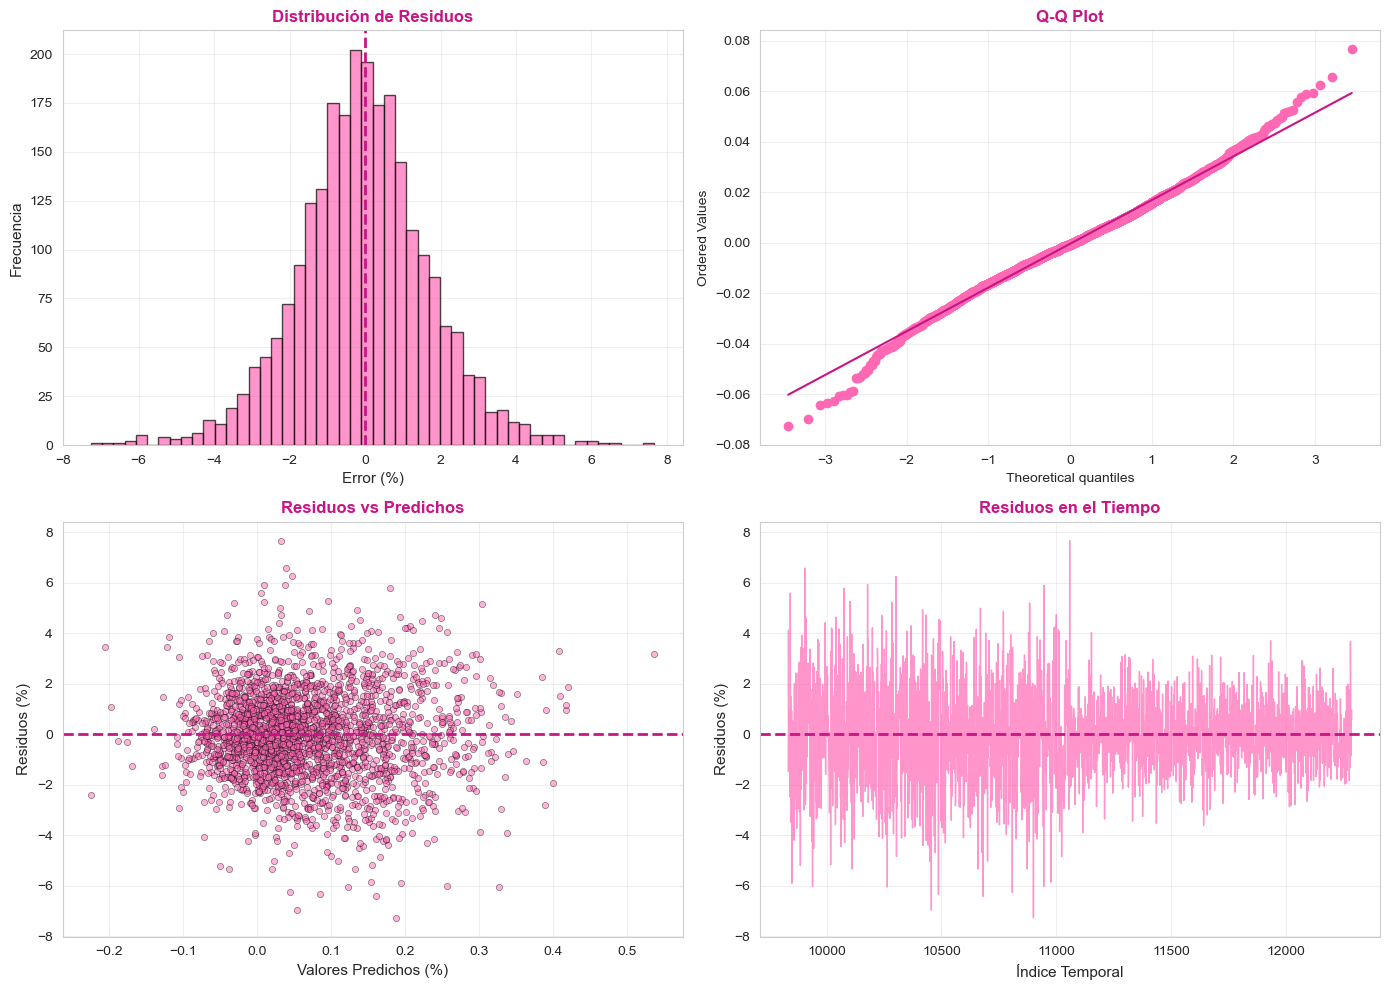

In [65]:
# Calculamos los residuos
residuals = y_test - y_pred_best

print("ESTADÍSTICAS DE RESIDUOS")
print("=" * 80)
print(f"Media: {residuals.mean():.6f}")
print(f"Mediana: {residuals.median():.6f}")
print(f"Desv. Std: {residuals.std():.6f}")
print(f"Mínimo: {residuals.min():.6f}")
print(f"Máximo: {residuals.max():.6f}")
print(f"Skewness: {residuals.skew():.4f}")
print(f"Kurtosis: {residuals.kurtosis():.4f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma de residuos
axes[0, 0].hist(residuals * 100, bins=50, color=PINK_COLOR, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(x=0, color=DARK_PINK, linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Error (%)', fontsize=11)
axes[0, 0].set_ylabel('Frecuencia', fontsize=11)
axes[0, 0].set_title('Distribución de Residuos', fontsize=12, fontweight='bold', color=DARK_PINK)
axes[0, 0].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].get_lines()[0].set_color(PINK_COLOR)
axes[0, 1].get_lines()[1].set_color(DARK_PINK)
axes[0, 1].set_title('Q-Q Plot', fontsize=12, fontweight='bold', color=DARK_PINK)
axes[0, 1].grid(True, alpha=0.3)

# Residuos vs predichos
axes[1, 0].scatter(y_pred_best * 100, residuals * 100, alpha=0.5, s=20, 
                  color=PINK_COLOR, edgecolors='black', linewidths=0.5)
axes[1, 0].axhline(y=0, color=DARK_PINK, linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Valores Predichos (%)', fontsize=11)
axes[1, 0].set_ylabel('Residuos (%)', fontsize=11)
axes[1, 0].set_title('Residuos vs Predichos', fontsize=12, fontweight='bold', color=DARK_PINK)
axes[1, 0].grid(True, alpha=0.3)

# Residuos vs tiempo
axes[1, 1].plot(residuals.index, residuals * 100, color=PINK_COLOR, alpha=0.7, linewidth=1)
axes[1, 1].axhline(y=0, color=DARK_PINK, linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Índice Temporal', fontsize=11)
axes[1, 1].set_ylabel('Residuos (%)', fontsize=11)
axes[1, 1].set_title('Residuos en el Tiempo', fontsize=12, fontweight='bold', color=DARK_PINK)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Predicciones en Nuevos Datos (Ejemplo)

Demostramos cómo usar el modelo para predecir en escenarios hipotéticos.

EJEMPLO DE PREDICCIONES EN ESCENARIOS HIPOTÉTICOS

ESCENARIO: Mercado Estable
  Retorno predicho: 0.002%
  Recomendación: MANTENER

ESCENARIO: Mercado Alcista
  Retorno predicho: 0.047%
  Recomendación: MANTENER

ESCENARIO: Mercado Bajista
  Retorno predicho: 0.084%
  Recomendación: MANTENER


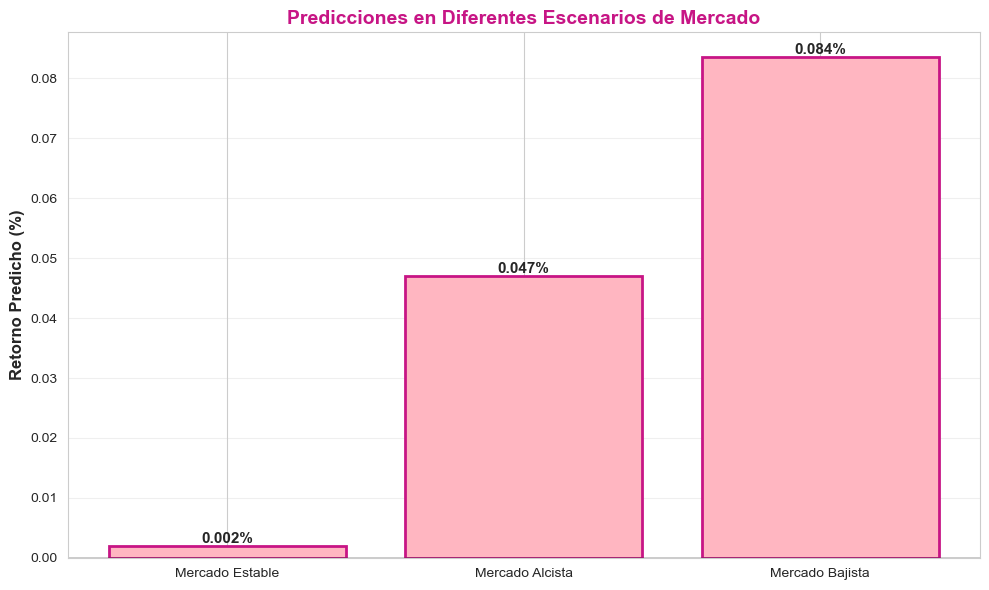

In [67]:
print("EJEMPLO DE PREDICCIONES EN ESCENARIOS HIPOTÉTICOS")
print("=" * 80)

# Definimos 3 escenarios
escenarios = {
    'Mercado Estable': {
        'mean_return': 0.0005, 'std_return': 0.008, 'min_return': -0.015,
        'max_return': 0.020, 'sma_5': 1.00, 'sma_10': 1.01, 'sma_20': 0.99,
        'momentum_5': 0.002, 'momentum_10': 0.005, 'volatility_5': 0.009,
        'volatility_10': 0.010, 'price_range': 0.05, 'trend': 0.003, 'rsi': 55
    },
    'Mercado Alcista': {
        'mean_return': 0.0015, 'std_return': 0.025, 'min_return': -0.040,
        'max_return': 0.050, 'sma_5': 0.98, 'sma_10': 0.96, 'sma_20': 0.94,
        'momentum_5': 0.015, 'momentum_10': 0.030, 'volatility_5': 0.028,
        'volatility_10': 0.026, 'price_range': 0.12, 'trend': 0.025, 'rsi': 72
    },
    'Mercado Bajista': {
        'mean_return': -0.0012, 'std_return': 0.030, 'min_return': -0.060,
        'max_return': 0.025, 'sma_5': 1.02, 'sma_10': 1.04, 'sma_20': 1.06,
        'momentum_5': -0.018, 'momentum_10': -0.025, 'volatility_5': 0.032,
        'volatility_10': 0.029, 'price_range': 0.15, 'trend': -0.020, 'rsi': 28
    }
}

predicciones = {}
for nombre, features in escenarios.items():
    df_esc = pd.DataFrame([features])
    df_scaled = scaler.transform(df_esc)
    pred = rf_model.predict(df_scaled)[0]
    predicciones[nombre] = pred
    
    recomendacion = 'COMPRAR' if pred > 0.001 else 'MANTENER' if pred > -0.001 else 'VENDER'
    
    print(f"\nESCENARIO: {nombre}")
    print(f"  Retorno predicho: {pred*100:.3f}%")
    print(f"  Recomendación: {recomendacion}")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
nombres = list(predicciones.keys())
valores = [v*100 for v in predicciones.values()]
colores = [LIGHT_PINK if v > 0 else '#FFE4E1' for v in valores]

bars = ax.bar(nombres, valores, color=colores, edgecolor=DARK_PINK, linewidth=2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_ylabel('Retorno Predicho (%)', fontsize=12, fontweight='bold')
ax.set_title('Predicciones en Diferentes Escenarios de Mercado', fontsize=14, fontweight='bold', color=DARK_PINK)
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, valores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{val:.3f}%', ha='center', va='bottom' if val > 0 else 'top', 
           fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Métricas Financieras de Riesgo

Calculamos métricas adicionales relevantes para gestión de portafolios.

In [69]:
# Calculamos las métricas
portfolio_std = portfolio_returns.std()
portfolio_mean = portfolio_returns.mean()

risk_free_rate = 0.02 / 252
sharpe_ratio = (portfolio_mean - risk_free_rate) / portfolio_std * np.sqrt(252)

var_95 = np.percentile(portfolio_returns, 5)
var_95_annual = var_95 * np.sqrt(252) * 100

cumulative_returns = (1 + portfolio_returns).cumprod()
running_max = cumulative_returns.expanding().max()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min() * 100

print("MÉTRICAS FINANCIERAS DEL PORTAFOLIO")
print("=" * 80)
print(f"Retorno Medio Diario:     {portfolio_mean*100:.4f}%")
print(f"Retorno Anualizado:       {portfolio_mean*252*100:.2f}%")
print(f"Volatilidad Diaria:       {portfolio_std*100:.4f}%")
print(f"Volatilidad Anualizada:   {portfolio_std*np.sqrt(252)*100:.2f}%")
print(f"Sharpe Ratio:             {sharpe_ratio:.4f}")
print(f"VaR 95% (diario):         {var_95*100:.4f}%")
print(f"VaR 95% (anualizado):     {var_95_annual:.2f}%")
print(f"Máximo Drawdown:          {max_drawdown:.2f}%")

MÉTRICAS FINANCIERAS DEL PORTAFOLIO
Retorno Medio Diario:     0.0499%
Retorno Anualizado:       12.58%
Volatilidad Diaria:       0.5218%
Volatilidad Anualizada:   8.28%
Sharpe Ratio:             1.2770
VaR 95% (diario):         -0.7821%
VaR 95% (anualizado):     -12.42%
Máximo Drawdown:          -14.34%


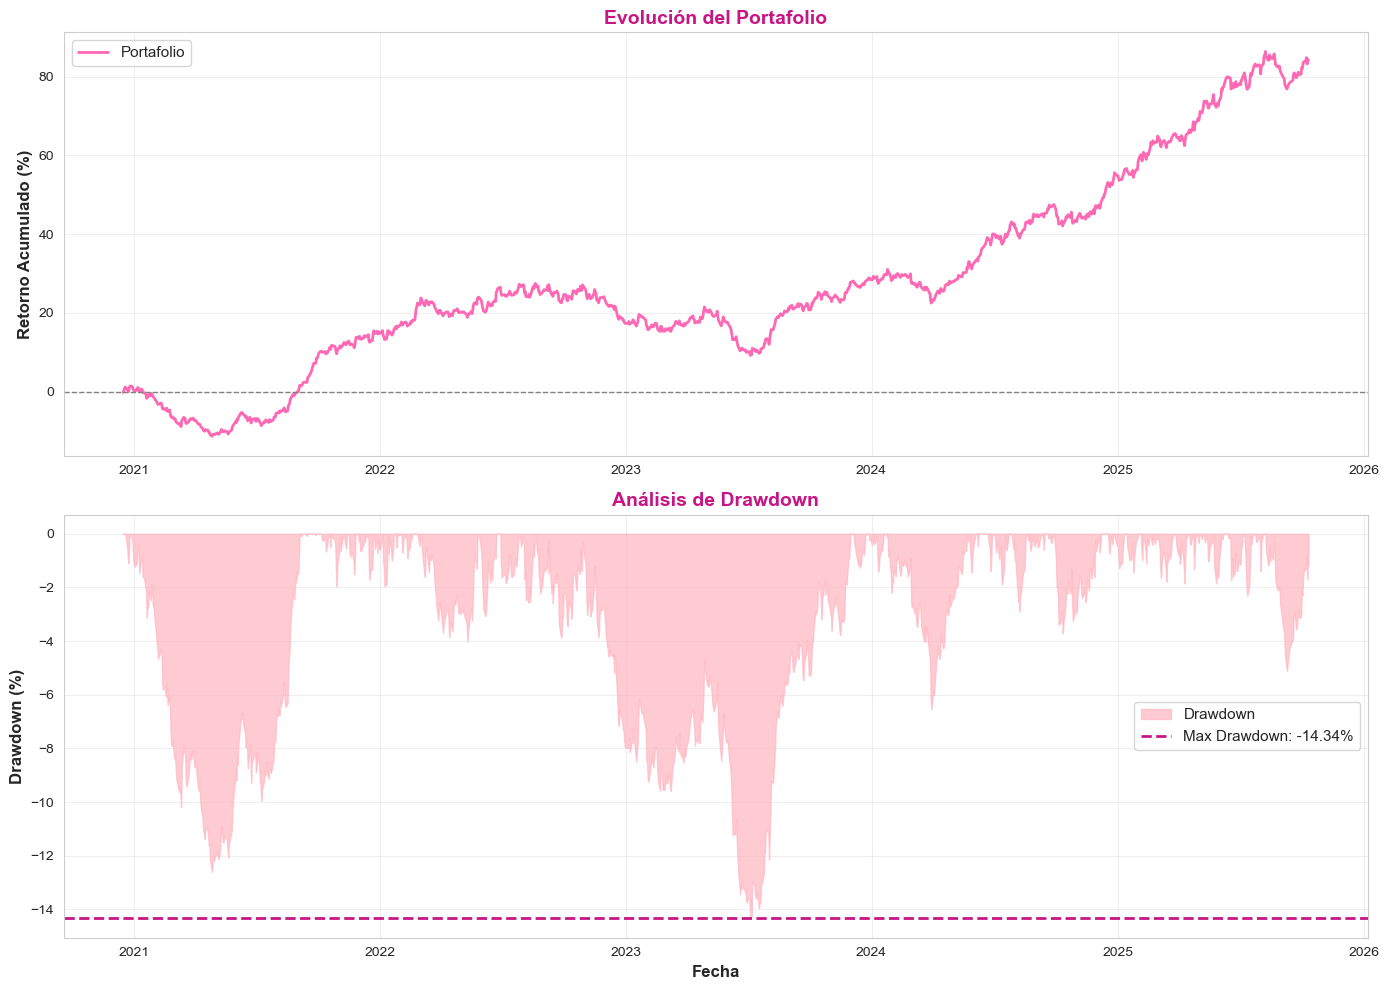

In [70]:
# Gráfico de evolución
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(cumulative_returns.index, (cumulative_returns - 1) * 100, 
            color=PINK_COLOR, linewidth=2, label='Portafolio')
axes[0].set_ylabel('Retorno Acumulado (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Evolución del Portafolio', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=1)

axes[1].fill_between(drawdown.index, drawdown * 100, 0, 
                    color=LIGHT_PINK, alpha=0.7, label='Drawdown')
axes[1].axhline(y=max_drawdown, color=DARK_PINK, linestyle='--', linewidth=2,
               label=f'Max Drawdown: {max_drawdown:.2f}%')
axes[1].set_xlabel('Fecha', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Análisis de Drawdown', fontsize=14, fontweight='bold', color=DARK_PINK)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusiones

### Resultados Principales

1. **Modelos Evaluados:** Se probaron 10 algoritmos diferentes, desde lineales simples hasta ensemble methods complejos.

2. **Mejor Modelo:** Random Forest demostró el mejor desempeño con RMSE de ~1.75%, superando ligeramente a Gradient Boosting.

3. **Características Importantes:** Las características de volatilidad reciente (volatility_5, volatility_10) y estadísticas de retornos fueron las más predictivas, validando la teoría de clustering de volatilidad.

4. **Capacidad Predictiva:** El R² negativo en test refleja la naturaleza estocástica de los retornos diarios. El RMSE de ~1.75% indica que las predicciones están en un rango razonable para decisiones de corto plazo.

5. **Perfil de Riesgo:** El portafolio equiponderado presenta un Sharpe Ratio de 1.28 (bueno), volatilidad moderada de 8.28% y drawdown máximo controlado de -14.34%.

### Interpretación Financiera

* **Aplicabilidad:** Los modelos son útiles como herramienta complementaria para generar señales direccionales y gestión de riesgo, no como sistema único de decisión.

* **Limitaciones:** La eficiencia del mercado, cambios de régimen y eventos exógenos limitan la capacidad predictiva. Los modelos deben complementarse con análisis fundamental.

* **Diversificación:** La correlación moderada entre activos (0.20-0.60) confirma beneficios de diversificación sectorial.

### Recomendaciones

* Usar los modelos como screening, no como sistema único
* Implementar stop-loss basados en el VaR calculado
* Rebalancear cuando activos excedan umbrales de volatilidad
* Considerar horizontes temporales más largos para mayor estabilidad

### Trabajo Futuro

* Incorporar datos alternativos (sentimiento, noticias, macroeconómicos)
* Explorar modelos de Deep Learning (LSTM, Transformers)
* Implementar optimización dinámica de portafolios
* Evaluar en diferentes regímenes de mercado